In [1]:
# 我想把整个var过程做如下改动：
# 输入—— T1、T2长度 选择的因子
# 过程就是 T1+T2一起平移 用T1预测T2 
# 输出—— 在整个过程中 每一段T2预测各因子的MAPE 预测结果储存
# 目的：选取最优的T1、T2和因子

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson

In [2]:
def data_process(name,factors,t1,t2):
    
    df = pd.read_csv(name+".csv")
    df.index = df["datetime"]
    df = df.drop(columns=["datetime"])
#     drop_factors = df.columns.tolist()-factors
    drop_factors = list(set(df.columns.tolist()).difference(set(factors)))
    df = df.drop(columns=drop_factors)  
    return df

In [3]:
# Select the Order (P) of VAR model

def select_p(df):
    
    model = VAR(df)
    AIC = []
    for i in range(1,20):
        result = model.fit(i)
        AIC.append(result.aic)
        
    p = 1
    
    flag=False
    
    if(len(AIC)>1):
    
        for i in range(len(AIC)-1):

            if(AIC[i+1]>AIC[i]):
                
                flag=True
                p=i+1
                break
    
    if(flag==False):
        
        p=20
    
    return p       

In [4]:
# 将一阶或二阶差分还原

def invert_transformation(df_train, df_forecast, second_diff=False):
    
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [5]:
# 计算mape 预测的准确性

def forecast_accuracy(forecast, actual):
    
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    return mape

In [14]:
def run(df,t1,t2):
    
#     df.index = pd.DatetimeIndex(df.index).to_period(freq='') 
    
    # 根据t1 t2划分训练集和测试集
    train = df[0:t1]
    test = df[t1:]
    
    # 1st difference
    diff_train = train.diff().dropna()
    # 2st difference
    diffdiff_train = diff_train.diff().dropna()
    print("diffdiff_train")
    print(diffdiff_train)
    
    # 确定lag order
    p = select_p(diffdiff_train)
    
    # 建立VAR模型
    model = VAR(diffdiff_train)
    model_fitted = model.fit(p)
#     model_fitted.summary()
    
    # 预测
    forecast_input = diffdiff_train.values[-p:]
    fc = model_fitted.forecast(y=forecast_input, steps=t2)
    df_forecast = pd.DataFrame(fc, index=df.index[-t2:], columns=df.columns + '_2d')
    print("df_forecast")
    print(df_forecast)
    
    # 将差分还原
    df_results = invert_transformation(train, df_forecast, second_diff=True)    
    # 这里注意要改
#     df_results = df_results.loc[:, ['spread_forecast', 'basis_forecast', 'index_volatility_forecast']]
#     df_results = df_results.loc[:, ['spread_forecast', 'index_volatility_forecast']]  
    df_results = df_results.loc[:, ['spread_forecast', 'hs300_forecast']]  
#     df_results = df_results.loc[:, ['spread_forecast', 'hs300_forecast','IF2009open_interest_forecast']]  
    
#     print(test)
#     print(df_results)
    
    # 用mape衡量预测spread的准确性
    accuracy_prod = forecast_accuracy(df_results['spread_forecast'].values, test['spread'])
    
    print("forecast")
    print(list(df_results['spread_forecast'].values))
    
#     print(accuracy_prod)
      
    return df_results,accuracy_prod

In [15]:
def loop(name,factors,t1,t2):
    
    df = data_process(name,factors,t1,t2)
    print(df.head())
    start = 0
    end = t1+t2
    data_history = df[start:end]
    
    turns = int((len(df)-t1)/t2)
#     print(len(df))
#     print(turns)

    # 存储预测accuracy(mape)
    train_start = []
    train_start.clear()
    train_end = []
    train_end.clear()
    test_start = []
    test_start.clear()
    test_end = []
    test_end.clear()
    all_mape = []
    all_mape.clear()
    
    for turn in range(turns):
#     for turn in range(3):
        
        data = df[start:end]
        results,mape = run(data,t1,t2)
        
        if(turn!=0):
            data_history=data_history.append(data[t1:])

        # prediction 存储预测结果
        test = data[t1:]
        pred_turn = pd.concat([test,results], axis=1)
        if(turn==0):
            prediction = pred_turn
        else:
            prediction = prediction.append(pred_turn)
        
        # 存储预测accuracy(mape)
        train_start.append(data.index[0])
        train_end.append(data.index[t1-1])
        test_start.append(data.index[t1])
        test_end.append(data.index[t1+t2-1])
        all_mape.append(mape)  
        
        start = start+t2
        end = end+t2
        
        if(turn==0 or turn ==1 or turn ==2):
            
            print("turn "+str(turn))
            print("data")
            print(data)
            print("data history")
            print(data_history)
            
    accuracy = {'train_start':train_start,'train_end':train_end,'test_start':test_start,'test_end':test_end,'mape':all_mape}
    accuracy = pd.DataFrame.from_dict(accuracy)

    return prediction,accuracy

In [16]:
name = "IF2012-2009"
factors = ["spread","hs300"]
t1=180
t2=10  # 即frequency

prediction,accuracy = loop(name,factors,t1,t2)

print(prediction.head())
print(accuracy.head())

# warning不用管它 不影响 我也不知道怎么去掉

                spread    hs300
datetime                       
2020/6/17 9:32   -60.6  4004.86
2020/6/17 9:33   -60.4  4003.26
2020/6/17 9:34   -61.2  4002.31
2020/6/17 9:35   -62.0  4005.03
2020/6/17 9:36   -61.6  4006.74
diffdiff_train
                       spread  hs300
datetime                            
2020/6/17 9:34  -1.000000e+00   0.65
2020/6/17 9:35   7.105427e-15   3.67
2020/6/17 9:36   1.200000e+00  -1.01
2020/6/17 9:37  -1.400000e+00   1.69
2020/6/17 9:38   1.600000e+00  -5.86
...                       ...    ...
2020/6/17 13:58 -8.000000e-01   0.20
2020/6/17 13:59  1.000000e+00  -0.69
2020/6/17 14:00  8.000000e-01  -1.16
2020/6/17 14:01 -2.400000e+00   1.37
2020/6/17 14:02  1.000000e+00  -1.52

[178 rows x 2 columns]
df_forecast
                 spread_2d  hs300_2d
datetime                            
2020/6/17 14:03   0.742249  0.397884
2020/6/17 14:04  -0.629922  0.711026
2020/6/17 14:05  -0.052082 -0.056722
2020/6/17 14:06   0.335146 -0.531293
2020/6/17 14:07  -0.15

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                 spread_2d  hs300_2d
datetime                            
2020/6/17 14:33  -0.472788 -1.073128
2020/6/17 14:34   1.100290 -0.265285
2020/6/17 14:35  -0.528508  0.519103
2020/6/17 14:36  -1.092375  0.008710
2020/6/17 14:37   1.810455 -0.971424
2020/6/17 14:38  -0.988640  0.683153
2020/6/17 14:39   0.240698 -0.120182
2020/6/17 14:40  -0.558972 -0.088907
2020/6/17 14:41   0.821817  0.056661
2020/6/17 14:42  -0.380751  0.154211
forecast
[-57.47278823908776, -56.845286351330614, -56.746292300323674, -57.73967313022672, -56.922599184884334, -57.094165021452845, -57.02503334324153, -57.514873357437615, -57.18289640892019, -57.23167014897249]
diffdiff_train
                 spread  hs300
datetime                      
2020/6/17 10:14    -3.4   1.03
2020/6/17 10:15     2.8   1.44
2020/6/17 10:16    -2.0  -1.52
2020/6/17 10:17     2.8   1.30
2020/6/17 10:18    -1.6   0.86
...                 ...    ...
2020/6/17 14:38     0.6  -0.23
2020/6/17 14:39     0.4  -1.04
2020

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                spread_2d  hs300_2d
datetime                           
2020/6/18 9:43   0.358731 -2.100487
2020/6/18 9:44   0.530526  0.029353
2020/6/18 9:45  -0.158847  1.671886
2020/6/18 9:46  -0.831616 -1.929339
2020/6/18 9:47   0.569629  0.045798
2020/6/18 9:48   0.598174  1.345068
2020/6/18 9:49  -1.058273 -0.464491
2020/6/18 9:50   0.396135 -0.617109
2020/6/18 9:51   0.374322  0.708167
2020/6/18 9:52  -0.156811 -0.011185
forecast
[-54.84126869733391, -54.55201144772285, -54.42160163101851, -55.12280744593321, -55.254384757941196, -54.787787889836494, -55.37946416475317, -55.57500526650642, -55.39622409301668, -55.37425372983299]
diffdiff_train
                       spread  hs300
datetime                            
2020/6/17 10:54 -2.400000e+00   1.21
2020/6/17 10:55 -2.000000e-01  -0.05
2020/6/17 10:56 -7.105427e-15  -0.77
2020/6/17 10:57  2.200000e+00   0.80
2020/6/17 10:58 -8.000000e-01  -2.40
...                       ...    ...
2020/6/18 9:48  -4.000000e-01   0

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                 spread_2d  hs300_2d
datetime                            
2020/6/18 10:13  -1.819615  0.456827
2020/6/18 10:14   1.206554  0.632636
2020/6/18 10:15  -0.717424 -0.430563
2020/6/18 10:16  -0.088764 -0.061858
2020/6/18 10:17   0.814421  0.244447
2020/6/18 10:18  -0.647593 -0.150931
2020/6/18 10:19   0.874129  0.415152
2020/6/18 10:20  -0.913414 -0.337733
2020/6/18 10:21   0.388302  0.044242
2020/6/18 10:22  -0.207084 -0.355699
forecast
[-51.2196148517512, -50.43267559899796, -50.36316080412091, -50.3824104107147, -49.587238615338826, -49.43965932145904, -48.41795070204469, -48.309655919715105, -47.81305935973904, -47.5235463579292]
diffdiff_train
                 spread  hs300
datetime                      
2020/6/17 11:24     1.6  -0.51
2020/6/17 11:25    -1.2   2.41
2020/6/17 11:26    -1.6  -1.16
2020/6/17 11:27     3.0   0.42
2020/6/17 11:28    -2.6  -0.25
...                 ...    ...
2020/6/18 10:18    -0.8  -0.20
2020/6/18 10:19     0.4   1.30
2020/6/18 

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                 spread_2d  hs300_2d
datetime                            
2020/6/18 11:23   1.362955 -0.564065
2020/6/18 11:24  -0.538117  1.219153
2020/6/18 11:25   0.179059 -0.917139
2020/6/18 11:26  -0.838469 -1.099864
2020/6/18 11:27   0.830163  0.947709
2020/6/18 11:28  -0.036600  0.305050
2020/6/18 11:29  -0.311089 -0.296849
2020/6/18 13:01   0.286877 -0.005196
2020/6/18 13:02  -0.257748 -0.036486
2020/6/18 13:03   0.139214 -0.038791
forecast
[-45.43704527213427, -44.212207989080845, -42.80831167054119, -42.2428839442253, -40.84729363132335, -39.48830334760193, -38.44040216948986, -37.10562351173221, -36.02859245838853, -34.812347851792765]
diffdiff_train
                 spread  hs300
datetime                      
2020/6/17 14:05     1.4  -0.77
2020/6/17 14:06     0.0   1.10
2020/6/17 14:07     1.2   1.00
2020/6/17 14:08    -1.8  -0.12
2020/6/17 14:09     0.8  -1.09
...                 ...    ...
2020/6/18 11:28    -0.8  -0.81
2020/6/18 11:29     2.6   1.34
2020/6/1

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                 spread_2d  hs300_2d
datetime                            
2020/6/18 13:24  -0.209727  0.269595
2020/6/18 13:25  -0.233458 -0.519712
2020/6/18 13:26   0.198601 -0.046361
2020/6/18 13:27   0.091525  0.289707
2020/6/18 13:28  -0.101949 -0.190366
2020/6/18 13:29   0.050268  0.000215
2020/6/18 13:30  -0.030753  0.120777
2020/6/18 13:31  -0.032678 -0.064286
2020/6/18 13:32   0.059619 -0.047018
2020/6/18 13:33  -0.003817  0.064615
forecast
[-47.80972724974961, -48.05291275745686, -48.097497490940626, -48.05055737281534, -48.105566040431405, -48.110306582622066, -48.14579995821354, -48.21397087307095, -48.222523108707996, -48.23489283022694]
diffdiff_train
                 spread  hs300
datetime                      
2020/6/17 14:35     1.8   0.99
2020/6/17 14:36    -1.0   0.61
2020/6/17 14:37    -0.4   0.42
2020/6/17 14:38     0.6  -0.23
2020/6/17 14:39     0.4  -1.04
...                 ...    ...
2020/6/18 13:29    -0.6   0.31
2020/6/18 13:30     2.8   1.32
2020/

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                 spread_2d  hs300_2d
datetime                            
2020/6/18 13:54   0.312331 -0.449149
2020/6/18 13:55   0.359834 -0.274033
2020/6/18 13:56  -0.192101  0.057945
2020/6/18 13:57  -0.080565 -0.194400
2020/6/18 13:58   0.153039  0.171588
2020/6/18 13:59  -0.023844  0.140934
2020/6/18 14:00  -0.006342 -0.100622
2020/6/18 14:01  -0.165839  0.014458
2020/6/18 14:02   0.135816  0.114963
2020/6/18 14:03  -0.016528 -0.057942
forecast
[-49.88766935211069, -49.81550481742567, -49.93544099774018, -50.13594208683514, -50.18340456578661, -50.25471105228649, -50.3323596695494, -50.575846917478195, -50.68351859084203, -50.807718625377426]
diffdiff_train
                 spread  hs300
datetime                      
2020/6/18 9:35     -0.8   2.13
2020/6/18 9:36     -1.8  -6.37
2020/6/18 9:37      3.4   2.90
2020/6/18 9:38     -1.6   0.98
2020/6/18 9:39      0.0   0.62
...                 ...    ...
2020/6/18 13:59     0.0   0.11
2020/6/18 14:00     0.6  -3.15
2020/6/1

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                 spread_2d  hs300_2d
datetime                            
2020/6/18 14:24  -0.607580  0.140669
2020/6/18 14:25   0.300151  0.623662
2020/6/18 14:26   0.081815 -0.431830
2020/6/18 14:27  -0.350777  0.011653
2020/6/18 14:28   0.272639 -0.003886
2020/6/18 14:29  -0.155961  0.002774
2020/6/18 14:30   0.169118  0.062993
2020/6/18 14:31  -0.095498 -0.037879
2020/6/18 14:32  -0.029898 -0.017973
2020/6/18 14:33   0.049700 -0.004920
forecast
[-51.007579655498745, -50.91500782564559, -50.74062125257701, -50.917011451555055, -50.82076287620362, -50.88047513645998, -50.77106985055957, -50.757162630088956, -50.77315350312594, -50.73944404667786]
diffdiff_train
                 spread  hs300
datetime                      
2020/6/18 10:05     1.0  -2.88
2020/6/18 10:06    -2.0   2.29
2020/6/18 10:07     0.8   0.97
2020/6/18 10:08    -0.6   1.14
2020/6/18 10:09    -0.2   0.72
...                 ...    ...
2020/6/18 14:29     1.0   0.08
2020/6/18 14:30    -1.2   1.10
2020/6

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                 spread_2d  hs300_2d
datetime                            
2020/6/18 14:54   0.589180 -0.007157
2020/6/18 14:55   0.429543 -0.099599
2020/6/18 14:56  -0.081910 -0.370620
2020/6/18 14:57  -0.233298  0.014098
2020/6/18 14:58   0.178733  0.329326
2020/6/18 14:59   0.120119 -0.120202
2020/6/19 9:30   -0.138998 -0.247444
2020/6/19 9:31   -0.162046  0.247010
2020/6/19 9:32    0.149235  0.143280
2020/6/19 9:33   -0.013874 -0.161668
forecast
[-51.21082044737654, -50.99209814907126, -50.85528596840042, -50.95177198689262, -50.86952520328416, -50.6671592734718, -50.6037910126714, -50.70246906348585, -50.651912083997004, -50.6152288311776]
diffdiff_train
                 spread  hs300
datetime                      
2020/6/18 10:35    -4.4  -0.16
2020/6/18 10:36     4.4   0.12
2020/6/18 10:37    -3.4   0.28
2020/6/18 10:38     2.4   0.63
2020/6/18 10:39    -1.2  -2.27
...                 ...    ...
2020/6/18 14:59    -2.2   0.00
2020/6/19 9:30     -5.6   1.23
2020/6/19 9

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                 spread_2d  hs300_2d
datetime                            
2020/6/19 10:24  -2.985726  1.180069
2020/6/19 10:25   0.522467  0.066376
2020/6/19 10:26   1.247182 -2.584078
2020/6/19 10:27   0.219859  1.933456
2020/6/19 10:28  -0.486899 -0.002208
2020/6/19 10:29  -0.137627 -0.802367
2020/6/19 10:30   0.154259 -0.738545
2020/6/19 10:31   0.388862  1.738951
2020/6/19 10:32  -0.856204 -0.028010
2020/6/19 10:33   0.195917 -0.576354
forecast
[-43.78572616938429, -44.44898557247812, -43.86506281923683, -43.06128109521108, -42.74439823507556, -42.56514205175743, -42.231626456018105, -41.50924918709477, -41.64307574267565, -41.5809855676553]
diffdiff_train
                 spread  hs300
datetime                      
2020/6/18 13:06     0.4  -1.71
2020/6/18 13:07     0.2  -1.17
2020/6/18 13:08    -0.2   0.53
2020/6/18 13:09    -0.4  -0.13
2020/6/18 13:10     1.4  -0.77
...                 ...    ...
2020/6/19 10:29     0.6  -0.37
2020/6/19 10:30     0.8  -1.53
2020/6/19

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign


                 spread  hs300
datetime                      
2020/6/18 13:36     0.6   1.06
2020/6/18 13:37    -0.4   0.75
2020/6/18 13:38     0.6   0.92
2020/6/18 13:39    -1.6  -1.13
2020/6/18 13:40     1.4   0.77
...                 ...    ...
2020/6/19 10:59     1.0   0.57
2020/6/19 11:00    -0.8   0.50
2020/6/19 11:01    -0.4  -3.16
2020/6/19 11:02     2.6  -0.32
2020/6/19 11:03     0.6   0.84

[178 rows x 2 columns]
df_forecast
                 spread_2d  hs300_2d
datetime                            
2020/6/19 11:04  -2.921764  1.110126
2020/6/19 11:05   0.377529 -0.435694
2020/6/19 11:06   0.983235 -0.183162
2020/6/19 11:07   0.089534  0.286402
2020/6/19 11:08   0.132021 -0.230107
2020/6/19 11:09  -0.744126 -0.855507
2020/6/19 11:10  -0.038745  0.701829
2020/6/19 11:11   0.529819  0.502787
2020/6/19 11:12   0.027551 -0.214273
2020/6/19 11:13  -0.239709 -0.345131
forecast
[-40.92176420583743, -41.26599958776014, -40.62699996019515, -39.89846593194051, -39.03791041907729, -38.92

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                 spread_2d  hs300_2d
datetime                            
2020/6/19 13:05   1.835004  1.282871
2020/6/19 13:06  -0.344940  0.239354
2020/6/19 13:07   0.284726  0.303560
2020/6/19 13:08  -0.697315 -1.245174
2020/6/19 13:09   0.044169 -0.068805
2020/6/19 13:10   0.237658  0.759363
2020/6/19 13:11   0.294783  0.249516
2020/6/19 13:12  -0.343889 -0.226244
2020/6/19 13:13  -0.060977 -0.310870
2020/6/19 13:14   0.034554 -0.005265
forecast
[-43.36499564078492, -43.47493141968995, -43.30014104513408, -43.82266550268212, -44.30102046084439, -44.5417170557657, -44.48763017172656, -44.777431854792056, -45.12821084005659, -45.44443581749878]
diffdiff_train
                 spread  hs300
datetime                      
2020/6/18 14:16     2.4  -0.17
2020/6/18 14:17    -0.8  -1.93
2020/6/18 14:18     0.8   0.17
2020/6/18 14:19    -1.6   1.60
2020/6/18 14:20     0.8   0.18
...                 ...    ...
2020/6/19 13:10     1.4   2.10
2020/6/19 13:11    -0.4  -0.95
2020/6/19

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                 spread_2d  hs300_2d
datetime                            
2020/6/19 13:25   1.172647 -0.982264
2020/6/19 13:26  -0.691129  0.422574
2020/6/19 13:27   0.157751  0.534794
2020/6/19 13:28  -0.416523 -0.281768
2020/6/19 13:29  -0.010936  0.302134
2020/6/19 13:30   0.419022  0.038690
2020/6/19 13:31  -0.033926 -0.409891
2020/6/19 13:32  -0.250598  0.025790
2020/6/19 13:33   0.066945  0.120197
2020/6/19 13:34  -0.014254  0.099089
forecast
[-47.02735280346948, -47.5458350869416, -47.906566424605415, -48.68382053836009, -49.47201050864829, -49.8411789548283, -50.244273476402306, -50.89796595077359, -51.4847137059261, -52.08571526262227]
diffdiff_train
                       spread  hs300
datetime                            
2020/6/18 14:36 -7.105427e-15   1.32
2020/6/18 14:37  1.200000e+00  -0.94
2020/6/18 14:38 -8.000000e-01   0.30
2020/6/18 14:39  8.000000e-01  -1.79
2020/6/18 14:40 -1.800000e+00   1.21
...                       ...    ...
2020/6/19 13:30 -7.10542

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                 spread_2d  hs300_2d
datetime                            
2020/6/19 13:55  -2.405761 -1.413440
2020/6/19 13:56   1.873728 -0.757054
2020/6/19 13:57  -0.577652 -0.070539
2020/6/19 13:58   0.227334  0.628681
2020/6/19 13:59  -0.108007 -0.419453
2020/6/19 14:00   0.085891  0.777573
2020/6/19 14:01  -0.491763 -0.565119
2020/6/19 14:02   0.749560  0.445203
2020/6/19 14:03  -0.602066  0.215743
2020/6/19 14:04   0.207771 -0.461599
forecast
[-46.00576089529449, -45.33779356121664, -45.24747795580492, -44.92982831113452, -44.720185591062545, -44.42465186966926, -44.620881566521064, -44.067550777651284, -44.116285925411916, -43.957250465842215]
diffdiff_train
                 spread  hs300
datetime                      
2020/6/19 9:36     -0.2   7.25
2020/6/19 9:37     -0.4  -7.11
2020/6/19 9:38     -0.2  -1.29
2020/6/19 9:39      0.2   1.58
2020/6/19 9:40      2.6   1.85
...                 ...    ...
2020/6/19 14:00     2.2   2.21
2020/6/19 14:01    -1.8   0.63
2020

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                 spread_2d  hs300_2d
datetime                            
2020/6/19 14:35  -1.198746 -1.773749
2020/6/19 14:36  -0.034973 -0.354679
2020/6/19 14:37   0.705926 -0.212453
2020/6/19 14:38  -0.374498  0.430431
2020/6/19 14:39   0.150780  0.381691
2020/6/19 14:40  -0.134371 -0.021336
2020/6/19 14:41  -0.046983 -1.012841
2020/6/19 14:42   0.426328  0.687883
2020/6/19 14:43  -0.215378 -0.115792
2020/6/19 14:44  -0.166545  0.484087
forecast
[-37.99874639865987, -38.232465726680275, -37.760259002958364, -37.662549967192376, -37.41406119194393, -37.29994384289303, -37.2328097040838, -36.73934793995096, -36.46126394124406, -36.349725282118094]
diffdiff_train
                 spread  hs300
datetime                      
2020/6/19 10:16    -0.4  -1.29
2020/6/19 10:17    -0.6   2.21
2020/6/19 10:18    -3.2  -4.92
2020/6/19 10:19     4.8   2.80
2020/6/19 10:20    -0.6   0.25
...                 ...    ...
2020/6/19 14:40     1.6   1.51
2020/6/19 14:41     1.8  -2.36
2020/6

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                spread_2d  hs300_2d
datetime                           
2020/6/22 9:45  -0.183540 -3.515532
2020/6/22 9:46   0.141172  2.144080
2020/6/22 9:47  -0.984096 -0.687008
2020/6/22 9:48   0.950484 -0.687805
2020/6/22 9:49  -0.197071  1.404987
2020/6/22 9:50  -0.317780 -1.252113
2020/6/22 9:51   0.357362  0.689774
2020/6/22 9:52  -0.258452 -0.093288
2020/6/22 9:53   0.128811 -0.407928
2020/6/22 9:54  -0.002557  0.569051
forecast
[-16.583540077838475, -17.625908411180664, -19.652373148383628, -20.728353981765917, -22.00140554254874, -23.592237292734417, -24.825706590911217, -26.317628031160275, -27.68073863112737, -29.04640633026817]
diffdiff_train
                       spread  hs300
datetime                            
2020/6/19 10:56  6.000000e-01  -3.69
2020/6/19 10:57  1.400000e+00   2.56
2020/6/19 10:58 -1.400000e+00   0.56
2020/6/19 10:59  1.000000e+00   0.57
2020/6/19 11:00 -8.000000e-01   0.50
...                       ...    ...
2020/6/22 9:50   1.600000e+0

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign


forecast
[-17.633022453131602, -16.412419463794066, -16.560289539650366, -17.241592886877783, -16.446622694196385, -16.357965154764287, -16.111987203716318, -15.643864940128228, -15.534367015232032, -15.56980065217136]
diffdiff_train
                 spread  hs300
datetime                      
2020/6/19 11:26    -3.4   1.04
2020/6/19 11:27     2.2   0.04
2020/6/19 11:28    -1.2  -1.06
2020/6/19 11:29     0.0   0.26
2020/6/19 13:01     1.8   4.08
...                 ...    ...
2020/6/22 10:20    -1.0  -7.62
2020/6/22 10:21     1.8   6.84
2020/6/22 10:22    -1.4  -2.75
2020/6/22 10:23     0.6   2.13
2020/6/22 10:24    -0.6  -0.34

[178 rows x 2 columns]
df_forecast
                 spread_2d  hs300_2d
datetime                            
2020/6/22 10:25  -0.398743 -0.610006
2020/6/22 10:26   0.910502 -0.881624
2020/6/22 10:27  -0.579943  1.060746
2020/6/22 10:28   0.398335 -0.585408
2020/6/22 10:29  -0.045797  0.574841
2020/6/22 10:30  -0.166899 -0.144790
2020/6/22 10:31  -0.088311 -0.

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                 spread_2d  hs300_2d
datetime                            
2020/6/22 10:55  -0.043428  1.295722
2020/6/22 10:56   0.690218 -0.875129
2020/6/22 10:57  -0.352383  0.634900
2020/6/22 10:58  -0.090125 -0.007997
2020/6/22 10:59  -0.058774 -0.326115
2020/6/22 11:00   0.202812  0.016993
2020/6/22 11:01  -0.271403  0.181404
2020/6/22 11:02   0.247263 -0.164103
2020/6/22 11:03  -0.109504  0.163969
2020/6/22 11:04  -0.027598 -0.071248
forecast
[-20.64342771828996, -20.996637367976916, -21.702229969859268, -22.497947476139334, -23.35243858572908, -24.004117640598608, -24.92720014473201, -25.60301950600442, -26.3883432660663, -27.20126511512435]
diffdiff_train
                 spread  hs300
datetime                      
2020/6/19 13:37    -0.4   0.34
2020/6/19 13:38     0.8  -2.97
2020/6/19 13:39     1.8   1.75
2020/6/19 13:40    -0.2  -0.37
2020/6/19 13:41    -0.4   0.31
...                 ...    ...
2020/6/22 11:00     3.4  -0.73
2020/6/22 11:01    -2.0   2.44
2020/6

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                 spread_2d  hs300_2d
datetime                            
2020/6/22 11:25   0.316710 -0.476480
2020/6/22 11:26   0.555527 -0.590779
2020/6/22 11:27  -0.314366  0.399552
2020/6/22 11:28   0.292153  0.159159
2020/6/22 11:29  -0.321387  0.225013
2020/6/22 13:01  -0.000648 -0.161332
2020/6/22 13:02  -0.062141 -0.040726
2020/6/22 13:03   0.167888 -0.130777
2020/6/22 13:04  -0.074124  0.071179
2020/6/22 13:05   0.055073  0.016603
forecast
[-21.483290185703712, -21.8110538523793, -22.45318372757347, -22.803160392755622, -23.474524035597135, -24.14653570191856, -24.880688149438406, -25.446952112796467, -26.087340297902823, -26.67265565652157]
diffdiff_train
                 spread  hs300
datetime                      
2020/6/19 14:07     0.4  -0.25
2020/6/19 14:08    -1.4  -3.37
2020/6/19 14:09     0.0   2.89
2020/6/19 14:10     2.2   0.59
2020/6/19 14:11    -1.6  -0.80
...                 ...    ...
2020/6/22 13:01    -0.8  -1.05
2020/6/22 13:02     1.6   0.49
2020

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                 spread_2d  hs300_2d
datetime                            
2020/6/22 13:36   1.682839 -0.226632
2020/6/22 13:37  -0.888434  0.392543
2020/6/22 13:38   0.560279 -0.511882
2020/6/22 13:39  -0.220646  0.478864
2020/6/22 13:40  -0.006168  0.001963
2020/6/22 13:41  -0.228176 -0.167674
2020/6/22 13:42   0.309466  0.031105
2020/6/22 13:43  -0.252074 -0.007153
2020/6/22 13:44   0.152830 -0.077628
2020/6/22 13:45  -0.086306  0.113756
forecast
[-22.517160789645413, -23.32275572194402, -23.56807189505035, -24.034033633387978, -24.50616325009777, -25.206468718344738, -25.59730812702167, -26.240221333303193, -26.73030406267754, -27.30669262867715]
diffdiff_train
                 spread  hs300
datetime                      
2020/6/19 14:47    -0.4  -0.88
2020/6/19 14:48     2.4  -0.59
2020/6/19 14:49     1.4   0.04
2020/6/19 14:50    -5.2   0.74
2020/6/19 14:51     5.6   1.54
...                 ...    ...
2020/6/22 13:41    -0.4   0.25
2020/6/22 13:42     1.6  -2.36
2020/

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                 spread_2d  hs300_2d
datetime                            
2020/6/22 14:16  -0.121728  2.469345
2020/6/22 14:17   0.461241 -0.197374
2020/6/22 14:18  -0.552163  0.273154
2020/6/22 14:19   0.138850  0.553572
2020/6/22 14:20  -0.252847 -0.539916
2020/6/22 14:21   1.078928  0.254420
2020/6/22 14:22  -1.131508 -0.568287
2020/6/22 14:23   0.682306 -0.172648
2020/6/22 14:24  -0.267109  0.281211
2020/6/22 14:25  -0.012023 -0.114922
forecast
[-25.121727676128582, -24.78221445589721, -24.994864151550907, -25.068664132764983, -25.395310970102305, -24.643030299072013, -25.022257172422545, -24.719178292498864, -24.683208059731218, -24.65926091488797]
diffdiff_train
                       spread  hs300
datetime                            
2020/6/22 9:57   1.200000e+00   2.77
2020/6/22 9:58   6.000000e-01   0.04
2020/6/22 9:59  -1.000000e+00   0.14
2020/6/22 10:00  3.552714e-15   1.16
2020/6/22 10:01  2.000000e-01   3.27
...                       ...    ...
2020/6/22 14:21

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign


                 spread  hs300
datetime                      
2020/6/22 10:27    -3.4  -0.48
2020/6/22 10:28     1.8  -1.53
2020/6/22 10:29    -1.4   0.36
2020/6/22 10:30     3.0   1.92
2020/6/22 10:31    -4.2  -0.94
...                 ...    ...
2020/6/22 14:51     1.8   1.06
2020/6/22 14:52    -3.2  -0.52
2020/6/22 14:53     1.8   0.63
2020/6/22 14:54    -0.8   0.09
2020/6/22 14:55    -2.0  -2.68

[178 rows x 2 columns]
df_forecast
                 spread_2d  hs300_2d
datetime                            
2020/6/22 14:56   3.244832  1.561833
2020/6/22 14:57  -0.677405  0.380191
2020/6/22 14:58   0.093992  0.131030
2020/6/22 14:59  -1.003799 -0.047020
2020/6/23 9:31    0.530842 -0.216594
2020/6/23 9:32   -0.079597  0.122438
2020/6/23 9:33   -0.650565 -0.177175
2020/6/23 9:34    1.293378  0.270566
2020/6/23 9:35   -0.720993 -0.255518
2020/6/23 9:36    0.314873 -0.022493
forecast
[-25.755168274332867, -25.387741983612298, -24.926324024435086, -25.468704642826694, -25.48024330706744, -2

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                 spread_2d  hs300_2d
datetime                            
2020/6/23 10:07   0.696591  3.670634
2020/6/23 10:08  -0.651508 -0.251940
2020/6/23 10:09   0.938485  0.159444
2020/6/23 10:10  -0.213396 -0.016784
2020/6/23 10:11  -0.582790 -0.243341
2020/6/23 10:12   0.630033  0.034825
2020/6/23 10:13  -0.356590 -0.365607
2020/6/23 10:14   0.264323 -0.070305
2020/6/23 10:15  -0.290838  0.234481
2020/6/23 10:16   0.308213  0.081223
forecast
[-30.90340875662725, -31.258325522575227, -30.674757625926258, -30.30458603187367, -30.51720415735474, -30.099789718739654, -30.03896577737881, -29.713819331617266, -29.679511301062742, -29.336990107652785]
diffdiff_train
                 spread  hs300
datetime                      
2020/6/22 11:17    -1.6   2.68
2020/6/22 11:18     2.2  -0.01
2020/6/22 11:19    -1.0  -0.64
2020/6/22 11:20     0.4  -2.75
2020/6/22 11:21    -0.2   2.83
...                 ...    ...
2020/6/23 10:12    -0.2  -0.54
2020/6/23 10:13     0.2   1.75
202

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign


                 spread_2d  hs300_2d
datetime                            
2020/6/23 10:47   0.162882 -1.346048
2020/6/23 10:48   0.072907 -0.042125
2020/6/23 10:49   0.392635  0.046041
2020/6/23 10:50   0.374547 -0.013131
2020/6/23 10:51  -0.243282 -0.676551
2020/6/23 10:52  -0.686013 -0.462361
2020/6/23 10:53  -0.030163  0.401203
2020/6/23 10:54   0.092582  0.667532
2020/6/23 10:55   0.485732  0.233742
2020/6/23 10:56   0.021129 -0.193155
forecast
[-32.237118074695545, -32.40132949142137, -32.172905743403724, -31.569935194679875, -31.210246778646678, -31.53657088497599, -31.893058453757213, -32.15696452124861, -31.93513905556815, -31.692184384630814]
diffdiff_train
                 spread  hs300
datetime                      
2020/6/22 13:28     2.2  -1.48
2020/6/22 13:29    -2.2   0.51
2020/6/22 13:30     0.4  -3.23
2020/6/22 13:31    -0.4   2.59
2020/6/22 13:32     2.0  -1.62
...                 ...    ...
2020/6/23 10:52    -1.6   2.74
2020/6/23 10:53     1.0  -2.37
2020/6/23 10:5

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign


[-33.398871560795456, -33.9487593403895, -34.712553739858265, -34.9817135556212, -35.269928169526075, -35.201225639164605, -35.67059858115238, -36.183520524020835, -36.74633489809743, -37.277590719367076]
diffdiff_train
                 spread  hs300
datetime                      
2020/6/22 14:08     2.0   0.89
2020/6/22 14:09    -1.0  -0.75
2020/6/22 14:10     0.4  -0.13
2020/6/22 14:11     0.2   1.20
2020/6/22 14:12    -1.8  -0.29
...                 ...    ...
2020/6/23 13:03     1.8  -0.77
2020/6/23 13:04    -2.0   1.41
2020/6/23 13:05    -1.0   1.87
2020/6/23 13:06     2.8  -0.96
2020/6/23 13:07    -2.4  -0.07

[178 rows x 2 columns]
df_forecast
                 spread_2d  hs300_2d
datetime                            
2020/6/23 13:08   1.235943 -0.119037
2020/6/23 13:09  -0.283992  0.434735
2020/6/23 13:10   0.144445 -0.500830
2020/6/23 13:11   0.445167  0.124209
2020/6/23 13:12  -0.888147 -0.792617
2020/6/23 13:13   0.223493  0.903099
2020/6/23 13:14   0.009079  0.204053
2020/6/

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                 spread_2d  hs300_2d
datetime                            
2020/6/23 13:38  -0.362770 -1.287550
2020/6/23 13:39   1.322628  1.096258
2020/6/23 13:40  -0.972486 -0.487160
2020/6/23 13:41   0.080397  0.462927
2020/6/23 13:42   0.087872 -0.527042
2020/6/23 13:43  -0.737728 -0.437301
2020/6/23 13:44   0.872205  0.500682
2020/6/23 13:45  -0.223064  0.011199
2020/6/23 13:46   0.120518  0.013870
2020/6/23 13:47   0.079544  0.118748
forecast
[-31.962769518410944, -30.802910618361622, -30.6155374878747, -30.34776774853627, -29.992125784718787, -30.374211435218204, -29.884091797280277, -29.61703649038506, -29.229462825895297, -28.76234500927769]
diffdiff_train
                       spread  hs300
datetime                            
2020/6/22 14:48 -2.600000e+00   0.42
2020/6/22 14:49  2.400000e+00  -0.08
2020/6/22 14:50  0.000000e+00  -1.03
2020/6/22 14:51  1.800000e+00   1.06
2020/6/22 14:52 -3.200000e+00  -0.52
...                       ...    ...
2020/6/23 13:43 -6

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                 spread_2d  hs300_2d
datetime                            
2020/6/23 14:18  -0.625055  0.502736
2020/6/23 14:19   0.432333 -0.121957
2020/6/23 14:20  -0.348011  0.582390
2020/6/23 14:21  -0.203526 -0.274112
2020/6/23 14:22   0.176901  0.240930
2020/6/23 14:23   0.069488 -0.275971
2020/6/23 14:24  -0.163574 -0.191620
2020/6/23 14:25   0.299821  0.273115
2020/6/23 14:26  -0.138201 -0.165108
2020/6/23 14:27   0.032184  0.148522
forecast
[-31.825054621388812, -31.417776387840945, -31.35850957700525, -31.502768645552372, -31.470126694887476, -31.36799659633856, -31.429440566029577, -31.19106373492486, -31.090888163434077, -30.958528388083185]
diffdiff_train
                 spread  hs300
datetime                      
2020/6/23 9:59     -1.4   1.29
2020/6/23 10:00     2.0   2.86
2020/6/23 10:01    -2.2  -2.63
2020/6/23 10:02     2.0  -1.85
2020/6/23 10:03    -0.4   3.07
...                 ...    ...
2020/6/23 14:23    -0.6  -2.61
2020/6/23 14:24    -0.4   2.21
20

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                 spread_2d  hs300_2d
datetime                            
2020/6/23 14:58   1.026331  0.349494
2020/6/23 14:59  -0.431832  0.150130
2020/6/24 9:30    0.231479 -0.104035
2020/6/24 9:31    0.221598 -0.291177
2020/6/24 9:32   -0.281688  0.009747
2020/6/24 9:33   -0.007397  0.057086
2020/6/24 9:34    0.130337  0.198271
2020/6/24 9:35   -0.141641 -0.028504
2020/6/24 9:36    0.117522 -0.103302
2020/6/24 9:37   -0.065617 -0.033318
forecast
[-35.17366927098061, -35.579170443289215, -35.75319302699756, -35.70561768965094, -35.939730557081724, -36.18124068529206, -36.29241358714508, -36.54522740449799, -36.680519374632254, -36.88142869666314]
diffdiff_train
                 spread  hs300
datetime                      
2020/6/23 10:39     1.4   1.35
2020/6/23 10:40    -2.4  -0.35
2020/6/23 10:41     1.0   0.71
2020/6/23 10:42     0.6  -3.02
2020/6/23 10:43     0.6  -1.03
...                 ...    ...
2020/6/24 9:33     -0.8  -7.15
2020/6/24 9:34      2.0  10.44
2020/6

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                 spread_2d  hs300_2d
datetime                            
2020/6/24 10:08  -2.129517 -2.171864
2020/6/24 10:09   0.470346  0.702749
2020/6/24 10:10  -0.178132  1.430634
2020/6/24 10:11  -0.106542  0.265440
2020/6/24 10:12   0.033396 -0.286799
2020/6/24 10:13   0.107341 -0.165484
2020/6/24 10:14   0.133121 -0.446214
2020/6/24 10:15  -0.210201 -0.167357
2020/6/24 10:16   0.068120  0.295778
2020/6/24 10:17  -0.023769  0.410516
forecast
[-31.129516872142585, -30.788687840471397, -30.625990706844043, -30.569835586495802, -30.480284489945067, -30.283392720052085, -29.953380183663068, -29.83356878078781, -29.64563734249404, -29.48147517266346]
diffdiff_train
                       spread  hs300
datetime                            
2020/6/23 11:19  2.000000e-01   2.08
2020/6/23 11:20  2.000000e-01  -1.20
2020/6/23 11:21 -2.200000e+00  -0.27
2020/6/23 11:22 -1.600000e+00  -1.50
2020/6/23 11:23  4.600000e+00   3.04
...                       ...    ...
2020/6/24 10:13 

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign


                 spread_2d  hs300_2d
datetime                            
2020/6/24 10:48   2.429523 -0.674517
2020/6/24 10:49  -1.067671  0.025867
2020/6/24 10:50   0.302512  0.127874
2020/6/24 10:51  -0.125747  0.584192
2020/6/24 10:52  -0.182043 -0.450157
2020/6/24 10:53   0.361007  0.040507
2020/6/24 10:54  -0.322646  0.235384
2020/6/24 10:55   0.252690 -0.426778
2020/6/24 10:56  -0.144844  0.185850
2020/6/24 10:57   0.013967  0.058638
forecast
[-35.17047702257714, -36.00862489903489, -36.54426124274376, -37.20564444066012, -38.04907024510193, -38.531489412141546, -39.33655464924175, -39.888930285411945, -40.58615032019998, -41.26940326579986]
diffdiff_train
                 spread  hs300
datetime                      
2020/6/23 13:30     0.2  -1.13
2020/6/23 13:31    -2.6   2.50
2020/6/23 13:32     2.4   0.35
2020/6/23 13:33    -0.6   1.81
2020/6/23 13:34     4.2  -3.33
...                 ...    ...
2020/6/24 10:53     1.2   0.90
2020/6/24 10:54     0.0  -0.25
2020/6/24 10:55   

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                 spread_2d  hs300_2d
datetime                            
2020/6/24 13:39   2.362871  0.625136
2020/6/24 13:40  -0.237731 -0.647586
2020/6/24 13:41  -0.338096  0.078434
2020/6/24 13:42   0.203076 -0.112672
2020/6/24 13:43  -0.113609 -0.044196
2020/6/24 13:44  -0.085738  0.054673
2020/6/24 13:45   0.016464  0.441828
2020/6/24 13:46  -0.049673 -0.175933
2020/6/24 13:47   0.272444 -0.289266
2020/6/24 13:48  -0.173481  0.120256
forecast
[-38.03712875847562, -37.71198835653864, -37.72494376016372, -37.53482267768137, -37.458310651272356, -37.467537044884324, -37.460299444155204, -37.50273493188006, -37.27272655903612, -37.216198981307]
diffdiff_train
                       spread  hs300
datetime                            
2020/6/23 14:50  2.000000e-01  -1.36
2020/6/23 14:51  1.400000e+00   1.37
2020/6/23 14:52  4.000000e-01  -1.00
2020/6/23 14:53 -2.800000e+00  -0.75
2020/6/23 14:54  8.000000e-01   0.22
...                       ...    ...
2020/6/24 13:44 -1.400

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                 spread_2d  hs300_2d
datetime                            
2020/6/24 14:19  -1.307138 -0.169423
2020/6/24 14:20   0.149786  0.380725
2020/6/24 14:21  -0.026561  0.061290
2020/6/24 14:22   0.947598 -1.297755
2020/6/24 14:23  -0.536020  0.338657
2020/6/24 14:24  -0.496085  1.029951
2020/6/24 14:25   0.293941 -0.433473
2020/6/24 14:26   0.244396 -0.299210
2020/6/24 14:27  -0.100256  0.242283
2020/6/24 14:28  -0.067632  0.050373
forecast
[-34.10713821697672, -33.864490523945015, -33.64840391801607, -32.484719174686546, -31.85705481469377, -31.72547568468184, -31.299955947693032, -30.630040430231738, -30.060381330318386, -29.558353910955063]
diffdiff_train
                       spread  hs300
datetime                            
2020/6/24 10:00 -1.200000e+00  -0.21
2020/6/24 10:01  3.000000e+00  -4.69
2020/6/24 10:02 -2.000000e+00   2.22
2020/6/24 10:03  3.552714e-15   2.85
2020/6/24 10:04  1.000000e+00   0.55
...                       ...    ...
2020/6/24 14:24  

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                 spread_2d  hs300_2d
datetime                            
2020/6/24 14:59  -0.642382 -0.489623
2020/6/29 9:30   -0.080319  0.483333
2020/6/29 9:31    0.085894 -0.420364
2020/6/29 9:32    0.005490  0.103485
2020/6/29 9:33   -0.033026  0.043926
2020/6/29 9:34    0.130936  0.123647
2020/6/29 9:35   -0.147361 -0.126964
2020/6/29 9:36    0.029960  0.065999
2020/6/29 9:37    0.031621 -0.068177
2020/6/29 9:38   -0.003457  0.014933
forecast
[-35.242381622103665, -35.16508270759729, -35.001889405858016, -34.83320647456679, -34.69754919940284, -34.43095577375975, -34.311722962156594, -34.162529922850574, -33.9817155263562, -33.804357811662356]
diffdiff_train
                 spread  hs300
datetime                      
2020/6/24 10:40    -2.6  -2.02
2020/6/24 10:41     1.6  -0.15
2020/6/24 10:42    -1.8  -1.07
2020/6/24 10:43     2.6   1.59
2020/6/24 10:44    -3.0   0.72
...                 ...    ...
2020/6/29 9:34      3.4  -1.03
2020/6/29 9:35     -2.2   0.74
2020/

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                 spread_2d  hs300_2d
datetime                            
2020/6/29 10:09   0.299509 -0.664109
2020/6/29 10:10   0.268221  0.195697
2020/6/29 10:11   0.096063  0.007542
2020/6/29 10:12  -0.368382  0.234270
2020/6/29 10:13   0.148783 -0.171131
2020/6/29 10:14  -0.106682 -0.013132
2020/6/29 10:15   0.092966  0.049126
2020/6/29 10:16   0.036462 -0.013864
2020/6/29 10:17  -0.040950  0.011523
2020/6/29 10:18  -0.048681  0.000701
forecast
[-35.30049134933309, -35.33276135255429, -35.26896873826823, -35.57355770244325, -35.729363177339394, -35.99185025130249, -36.16137129770281, -36.29442993953345, -36.46843896486796, -36.69112869027554]
diffdiff_train
                 spread  hs300
datetime                      
2020/6/24 11:20     2.8  -0.86
2020/6/24 11:21    -3.0   1.62
2020/6/24 11:22     0.4  -0.05
2020/6/24 11:23     2.0  -0.01
2020/6/24 11:24    -3.6  -0.15
...                 ...    ...
2020/6/29 10:14     3.0  -2.00
2020/6/29 10:15    -1.4   0.85
2020/6/2

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                 spread_2d  hs300_2d
datetime                            
2020/6/29 10:49  -0.317557  0.117808
2020/6/29 10:50   0.186847 -0.382287
2020/6/29 10:51  -0.489814  0.318979
2020/6/29 10:52   0.074708 -0.070173
2020/6/29 10:53   0.283168  0.082193
2020/6/29 10:54  -0.055434 -0.127842
2020/6/29 10:55  -0.060734  0.086865
2020/6/29 10:56  -0.016917 -0.073114
2020/6/29 10:57  -0.055442  0.077042
2020/6/29 10:58   0.071581  0.008832
forecast
[-36.917557338814355, -36.84826730627122, -37.268791130223796, -37.61460744045022, -37.67725620464481, -37.79533864803589, -37.97415542647551, -38.16988908362572, -38.42106472674495, -38.600659353619896]
diffdiff_train
                 spread  hs300
datetime                      
2020/6/24 13:31    -0.8   2.71
2020/6/24 13:32    -0.4   0.20
2020/6/24 13:33     0.2  -1.08
2020/6/24 13:34    -0.8  -0.65
2020/6/24 13:35     2.8  -0.11
...                 ...    ...
2020/6/29 10:54    -0.6  -1.48
2020/6/29 10:55     0.6  -0.32
2020/6

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                 spread_2d  hs300_2d
datetime                            
2020/6/29 11:29  -1.447549  0.100231
2020/6/29 13:01   0.527759  0.184247
2020/6/29 13:02   0.286870 -0.323788
2020/6/29 13:03  -0.274289  0.151193
2020/6/29 13:04  -0.092643  0.018614
2020/6/29 13:05   0.226413 -0.024561
2020/6/29 13:06  -0.096432 -0.018280
2020/6/29 13:07  -0.041627  0.039669
2020/6/29 13:08   0.047469 -0.013587
2020/6/29 13:09   0.007482 -0.000952
forecast
[-34.04754871492828, -33.96733886070574, -33.60025933927161, -33.507468548500526, -33.50732065211549, -33.28075971977444, -33.15063126196528, -33.06212946290422, -32.926158383561386, -32.782705263327465]
diffdiff_train
                 spread  hs300
datetime                      
2020/6/24 14:11     1.0   1.11
2020/6/24 14:12    -1.4  -2.17
2020/6/24 14:13     3.0  -0.25
2020/6/24 14:14    -2.2   2.03
2020/6/24 14:15     2.2  -0.78
...                 ...    ...
2020/6/29 13:05     1.4   0.73
2020/6/29 13:06    -0.8   1.47
2020/6

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                 spread_2d  hs300_2d
datetime                            
2020/6/29 13:40  -1.079333  0.342112
2020/6/29 13:41   0.659316 -0.681378
2020/6/29 13:42  -0.239169  0.110624
2020/6/29 13:43   0.013947 -0.255089
2020/6/29 13:44  -0.115880  0.158844
2020/6/29 13:45   0.178560 -0.148337
2020/6/29 13:46   0.065809  0.085366
2020/6/29 13:47  -0.161886 -0.112590
2020/6/29 13:48  -0.001944  0.267486
2020/6/29 13:49   0.072853 -0.170187
forecast
[-34.27933344634047, -33.69935078376704, -33.35853669877232, -33.00377521020221, -32.76489341360577, -32.34745115277934, -31.864199637238464, -31.542833827775446, -31.22341159411488, -30.83113603694976]
diffdiff_train
                       spread  hs300
datetime                            
2020/6/24 14:51 -6.000000e-01  -0.70
2020/6/24 14:52 -7.105427e-15   0.28
2020/6/24 14:53 -1.000000e+00   0.67
2020/6/24 14:54  2.400000e+00  -0.41
2020/6/24 14:55 -1.600000e+00  -0.77
...                       ...    ...
2020/6/29 13:45 -7.10

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                 spread_2d  hs300_2d
datetime                            
2020/6/29 14:20   0.232910  0.047566
2020/6/29 14:21   0.064034 -0.036485
2020/6/29 14:22   0.113903 -0.037250
2020/6/29 14:23  -0.258958  0.028200
2020/6/29 14:24   0.183282  0.006460
2020/6/29 14:25  -0.027828 -0.015078
2020/6/29 14:26  -0.019407  0.002537
2020/6/29 14:27  -0.012183  0.001472
2020/6/29 14:28   0.048023 -0.001401
2020/6/29 14:29  -0.030554 -0.002571
forecast
[-35.36709035270991, -35.07014663910195, -34.65930040333285, -34.50741254944539, -34.17224273368147, -33.86490052440804, -33.576965512274676, -33.30121351935821, -32.97743869716948, -32.684217666887]
diffdiff_train
                 spread  hs300
datetime                      
2020/6/29 10:01    -0.8   0.79
2020/6/29 10:02     3.2  -1.49
2020/6/29 10:03    -4.2   1.52
2020/6/29 10:04     0.4   0.39
2020/6/29 10:05     3.2  -0.24
...                 ...    ...
2020/6/29 14:25    -1.8   0.65
2020/6/29 14:26    -0.2   0.05
2020/6/29 

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                spread_2d  hs300_2d
datetime                           
2020/6/30 9:30   0.083631  0.444325
2020/6/30 9:31  -0.185489 -0.281457
2020/6/30 9:32   0.308135  0.016794
2020/6/30 9:33  -0.234871  0.060789
2020/6/30 9:34   0.030825 -0.058379
2020/6/30 9:35  -0.044196 -0.056424
2020/6/30 9:36   0.077303  0.095767
2020/6/30 9:37  -0.018118 -0.020040
2020/6/30 9:38   0.007543  0.004524
2020/6/30 9:39   0.008600  0.001899
forecast
[-38.51636852932457, -38.61822623118569, -38.41194873857731, -38.44054232217766, -38.438310454071924, -38.48027411223385, -38.44493518392844, -38.42771416275779, -38.402950108971055, -38.369586419239056]
diffdiff_train
                 spread  hs300
datetime                      
2020/6/29 10:41    -0.2  -1.73
2020/6/29 10:42    -0.4  -1.09
2020/6/29 10:43    -0.2   0.82
2020/6/29 10:44     3.0   0.99
2020/6/29 10:45    -2.8  -0.60
...                 ...    ...
2020/6/30 9:35      0.8   3.50
2020/6/30 9:36     -2.0   0.05
2020/6/30 9:37    

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                 spread_2d  hs300_2d
datetime                            
2020/6/30 10:10   1.604291 -1.746784
2020/6/30 10:11  -0.754881  0.836483
2020/6/30 10:12   0.366084 -0.053535
2020/6/30 10:13   0.029665 -0.582125
2020/6/30 10:14   0.070143  0.462044
2020/6/30 10:15  -0.245504  0.163430
2020/6/30 10:16  -0.034105 -0.241327
2020/6/30 10:17   0.246254 -0.037247
2020/6/30 10:18  -0.257203  0.217289
2020/6/30 10:19   0.223985 -0.193094
forecast
[-38.7957089494138, -39.146298840337, -39.1308050375012, -39.08564614396146, -38.97034434770289, -39.10054689198088, -39.26485451003807, -39.18290789241828, -39.35816416299011, -39.30943508915045]
diffdiff_train
                 spread  hs300
datetime                      
2020/6/29 11:21    -1.8  -0.25
2020/6/29 11:22     2.0  -0.46
2020/6/29 11:23    -2.4   0.37
2020/6/29 11:24     1.0  -0.83
2020/6/29 11:25     1.4  -0.34
...                 ...    ...
2020/6/30 10:15     2.0   0.22
2020/6/30 10:16    -1.8  -0.99
2020/6/30 10:

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                 spread_2d  hs300_2d
datetime                            
2020/6/30 10:50  -0.602735  0.187688
2020/6/30 10:51  -0.360915 -1.050398
2020/6/30 10:52  -0.448276  0.459309
2020/6/30 10:53   0.926242  0.408749
2020/6/30 10:54  -0.706671  0.006794
2020/6/30 10:55   0.264798 -0.214773
2020/6/30 10:56  -0.009512  0.053645
2020/6/30 10:57   0.160043  0.079508
2020/6/30 10:58  -0.175700 -0.280618
2020/6/30 10:59  -0.133576  0.171408
forecast
[-40.20273541751827, -40.36638569984626, -40.9783122209085, -40.66399674508358, -41.0563521473611, -41.183909247467135, -41.32097857804609, -41.29800531383883, -41.45073219441061, -41.73703510980447]
diffdiff_train
                 spread  hs300
datetime                      
2020/6/29 13:32    -3.0   1.39
2020/6/29 13:33     3.6  -1.07
2020/6/29 13:34    -1.8   0.40
2020/6/29 13:35     1.0  -0.62
2020/6/29 13:36    -0.4   0.81
...                 ...    ...
2020/6/30 10:55     0.2   1.10
2020/6/30 10:56    -1.8  -2.16
2020/6/30 

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                 spread_2d  hs300_2d
datetime                            
2020/6/30 13:01   0.220486 -0.362544
2020/6/30 13:02  -0.326653 -0.232829
2020/6/30 13:03   0.166605 -0.286129
2020/6/30 13:04   0.172926 -0.038851
2020/6/30 13:05   0.082069 -0.438005
2020/6/30 13:06  -0.308499  0.211055
2020/6/30 13:07  -0.009985  0.377172
2020/6/30 13:08   0.220553 -0.036917
2020/6/30 13:09  -0.110272 -0.061023
2020/6/30 13:10  -0.033601 -0.077093
forecast
[-38.179513779647166, -38.28568041522575, -38.225241612977655, -37.99187698841969, -37.67644322900907, -37.6695084866189, -37.672558470479586, -37.4550558787724, -37.347825533959835, -37.27419668786063]
diffdiff_train
                       spread  hs300
datetime                            
2020/6/29 14:12  8.000000e-01   0.80
2020/6/29 14:13 -1.800000e+00  -0.55
2020/6/29 14:14  8.000000e-01   1.10
2020/6/29 14:15 -7.105427e-15  -0.43
2020/6/29 14:16  2.000000e-01  -0.04
...                       ...    ...
2020/6/30 13:06 -2.80

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                 spread_2d  hs300_2d
datetime                            
2020/6/30 13:41  -1.441095  3.420835
2020/6/30 13:42  -0.293224 -1.028534
2020/6/30 13:43   0.856612  0.020943
2020/6/30 13:44  -0.359946 -0.235970
2020/6/30 13:45  -0.230814  0.203295
2020/6/30 13:46   0.404999 -0.642313
2020/6/30 13:47   0.013851  0.543315
2020/6/30 13:48  -0.421484  0.006652
2020/6/30 13:49   0.233713 -0.143086
2020/6/30 13:50   0.021652  0.028041
forecast
[-39.04109496590705, -39.975413752602726, -40.05312089190344, -40.49077424334992, -41.15924118120695, -41.42270923772538, -41.672326340456365, -42.343427142076884, -42.780814871518466, -43.19655098451344]
diffdiff_train
                 spread  hs300
datetime                      
2020/6/29 14:52    -0.2   0.10
2020/6/29 14:53     0.2   0.32
2020/6/29 14:54     1.0  -0.60
2020/6/29 14:55    -0.6  -1.81
2020/6/29 14:56     0.2   2.02
...                 ...    ...
2020/6/30 13:46    -1.4  -0.03
2020/6/30 13:47     1.0   0.28
2020/

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                 spread_2d  hs300_2d
datetime                            
2020/6/30 14:11  -0.160272  0.008366
2020/6/30 14:12   0.187417  0.865560
2020/6/30 14:13  -0.125573  0.661739
2020/6/30 14:14  -0.286724  1.364359
2020/6/30 14:15   0.058306 -0.081006
2020/6/30 14:16   1.235237 -0.138999
2020/6/30 14:17  -0.418998 -0.590872
2020/6/30 14:18  -0.520231 -1.000313
2020/6/30 14:19   0.136839 -0.652969
2020/6/30 14:20   0.247595 -0.251222
forecast
[-37.76027165183965, -37.933126503126374, -38.231554417024405, -38.81670660129792, -39.34355250537698, -38.635161635351544, -38.34576869384654, -38.576607147404744, -38.67060661213936, -38.517011568942344]
diffdiff_train
                 spread  hs300
datetime                      
2020/6/30 9:52      0.6  -0.50
2020/6/30 9:53      0.0   0.32
2020/6/30 9:54      0.4  -2.17
2020/6/30 9:55     -1.2   1.57
2020/6/30 9:56      1.8  -0.03
...                 ...    ...
2020/6/30 14:16     2.0   0.13
2020/6/30 14:17    -2.0  -3.90
2020

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                 spread_2d  hs300_2d
datetime                            
2020/6/30 14:51  -0.974959 -0.511533
2020/6/30 14:52   1.447854 -0.392502
2020/6/30 14:53  -0.205393  0.554370
2020/6/30 14:54  -0.076314 -0.160101
2020/6/30 14:55  -0.423397  0.008635
2020/6/30 14:56   0.317060 -0.018940
2020/6/30 14:57   0.208029 -0.034013
2020/6/30 14:58  -0.237649  0.059385
2020/6/30 14:59  -0.049294 -0.053992
2020/7/1 9:30     0.091180  0.014230
forecast
[-39.174958530676996, -38.7020627521285, -38.43455972137293, -38.24337087189066, -38.47557880272665, -38.39072719855132, -38.09784634208962, -38.042614797225575, -38.036677462782166, -37.939559834616084]
diffdiff_train
                 spread  hs300
datetime                      
2020/6/30 10:32    -2.0   0.32
2020/6/30 10:33     3.2   0.19
2020/6/30 10:34    -2.4   1.70
2020/6/30 10:35     1.2  -1.15
2020/6/30 10:36    -2.8   0.20
...                 ...    ...
2020/6/30 14:56    -2.4   0.02
2020/6/30 14:57     0.0  -1.00
2020/6

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                spread_2d  hs300_2d
datetime                           
2020/7/1 10:01  -1.079829  3.223431
2020/7/1 10:02  -0.046565 -0.688574
2020/7/1 10:03   0.546730  0.592289
2020/7/1 10:04  -0.496351  0.259897
2020/7/1 10:05   0.112598  0.309591
2020/7/1 10:06   0.009154 -0.259558
2020/7/1 10:07   0.217452 -0.138410
2020/7/1 10:08  -0.030258 -0.615298
2020/7/1 10:09  -0.263239  0.398451
2020/7/1 10:10   0.196492 -0.124114
forecast
[-38.279829401652265, -38.40622427936765, -37.9858893918693, -38.06190524653525, -38.02532309016259, -37.97958657702554, -37.71639821714118, -37.48346814151443, -37.513777418257284, -37.34759495442056]
diffdiff_train
                 spread  hs300
datetime                      
2020/6/30 11:12    -0.2  -0.07
2020/6/30 11:13    -0.8  -0.37
2020/6/30 11:14    -0.8   1.06
2020/6/30 11:15     2.2  -0.85
2020/6/30 11:16    -1.2   0.33
...                 ...    ...
2020/7/1 10:06     -2.8  -0.54
2020/7/1 10:07      2.2  -3.73
2020/7/1 10:08      

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                spread_2d  hs300_2d
datetime                           
2020/7/1 10:41   2.512423  3.110510
2020/7/1 10:42  -0.775675  0.285737
2020/7/1 10:43  -0.059172 -0.092635
2020/7/1 10:44  -0.448739 -0.807687
2020/7/1 10:45   0.612659 -0.053556
2020/7/1 10:46  -0.020800  0.411146
2020/7/1 10:47  -0.356065 -0.053869
2020/7/1 10:48   0.136326 -0.043061
2020/7/1 10:49   0.077458 -0.104399
2020/7/1 10:50   0.050809  0.049248
forecast
[-40.487577479753824, -40.55083044792881, -40.67325524949544, -41.24441902496502, -41.20292354914355, -41.182228368767696, -41.51759793641988, -41.71664199771978, -41.83822840026749, -41.90900600986524]
diffdiff_train
                 spread  hs300
datetime                      
2020/6/30 13:23    -2.0   3.08
2020/6/30 13:24     1.6   0.65
2020/6/30 13:25    -2.2  -0.13
2020/6/30 13:26     0.6  -2.62
2020/6/30 13:27     3.2   0.92
...                 ...    ...
2020/7/1 10:46      1.8  -2.92
2020/7/1 10:47      0.0   1.48
2020/7/1 10:48     

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign


[-38.732328483459995, -38.921371000406694, -38.97413112267116, -39.22850696004594, -39.533310503038905, -39.22413313750492, -39.795057705703, -39.88496297566546, -39.90689187378268, -40.102808904350994]
diffdiff_train
                 spread  hs300
datetime                      
2020/6/30 13:53     1.2   0.81
2020/6/30 13:54    -0.6  -0.03
2020/6/30 13:55     0.8  -0.51
2020/6/30 13:56    -1.6  -0.95
2020/6/30 13:57    -0.2   0.11
...                 ...    ...
2020/7/1 11:16     -0.2  -1.27
2020/7/1 11:17      1.0   0.77
2020/7/1 11:18      0.6  -0.31
2020/7/1 11:19     -1.6   0.74
2020/7/1 11:20      1.4   0.26

[178 rows x 2 columns]
df_forecast
                spread_2d  hs300_2d
datetime                           
2020/7/1 11:21  -0.564211 -1.413453
2020/7/1 11:22   0.135976  0.654327
2020/7/1 11:23  -0.494746  0.182601
2020/7/1 11:24   0.420086 -0.252070
2020/7/1 11:25   0.147882  0.165994
2020/7/1 11:26  -0.342205  0.116465
2020/7/1 11:27   0.223046 -0.040217
2020/7/1 11:28  -0

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign


forecast
[-36.92124489514485, -36.98172273948804, -36.50474695228653, -36.76434004077784, -36.46877242798937, -36.84154794875209, -36.409309095543286, -36.53006415355182, -36.41997981564751, -36.344601878550186]
diffdiff_train
                       spread  hs300
datetime                            
2020/6/30 14:23 -8.000000e-01   0.53
2020/6/30 14:24  1.800000e+00  -0.45
2020/6/30 14:25 -3.800000e+00   0.33
2020/6/30 14:26  3.200000e+00  -0.88
2020/6/30 14:27 -2.000000e-01  -0.28
...                       ...    ...
2020/7/1 13:17  -7.105427e-15   1.74
2020/7/1 13:18  -6.000000e-01   1.66
2020/7/1 13:19   4.000000e-01  -0.67
2020/7/1 13:20   6.000000e-01   0.59
2020/7/1 13:21   1.600000e+00   1.85

[178 rows x 2 columns]
df_forecast
                spread_2d  hs300_2d
datetime                           
2020/7/1 13:22  -2.927146 -1.669380
2020/7/1 13:23   1.404796  0.269800
2020/7/1 13:24   0.145580 -0.289046
2020/7/1 13:25  -0.004343  0.473225
2020/7/1 13:26  -0.341010  0.084311
202

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign


                spread_2d  hs300_2d
datetime                           
2020/7/1 13:42   0.855686  0.046997
2020/7/1 13:43  -0.485451 -0.972169
2020/7/1 13:44   1.219302  0.794064
2020/7/1 13:45  -1.718941 -0.215698
2020/7/1 13:46   1.053497 -0.065413
2020/7/1 13:47  -0.429395 -0.211996
2020/7/1 13:48   0.273762  0.326892
2020/7/1 13:49  -0.094193 -0.095827
2020/7/1 13:50  -0.079374 -0.158988
2020/7/1 13:51   0.245669  0.133350
forecast
[-33.744313742590585, -33.774078577706, -32.584541067487805, -33.11394470119006, -32.58985160861856, -32.49515374553614, -32.12669398154774, -31.852427057705835, -31.65753421409501, -31.216972784648966]
diffdiff_train
                       spread  hs300
datetime                            
2020/6/30 14:53 -8.000000e-01   1.09
2020/6/30 14:54 -1.200000e+00   0.59
2020/6/30 14:55  1.800000e+00   0.36
2020/6/30 14:56 -2.400000e+00   0.02
2020/6/30 14:57  0.000000e+00  -1.00
...                       ...    ...
2020/7/1 13:47  -1.400000e+00  -1.10
2020/7/

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                spread_2d  hs300_2d
datetime                           
2020/7/1 14:12   0.421901 -0.134556
2020/7/1 14:13   0.214378  1.090380
2020/7/1 14:14  -1.994060 -1.005593
2020/7/1 14:15   1.737494 -0.351086
2020/7/1 14:16  -0.426910  1.012172
2020/7/1 14:17  -0.168160 -0.215573
2020/7/1 14:18   0.117069 -0.087927
2020/7/1 14:19   0.170264  0.052012
2020/7/1 14:20  -0.248781  0.072568
2020/7/1 14:21  -0.144336 -0.393396
forecast
[-37.57809898689446, -37.34181961135206, -39.09959976937958, -39.11988636696295, -39.56708301431173, -40.18243947744061, -40.680726844422395, -41.00874995730047, -41.585553833095254, -42.3066934095205]
diffdiff_train
                spread  hs300
datetime                     
2020/7/1 9:53     -1.4   1.23
2020/7/1 9:54      0.8  -3.26
2020/7/1 9:55     -0.2   2.74
2020/7/1 9:56      1.2   1.67
2020/7/1 9:57     -0.4   0.18
...                ...    ...
2020/7/1 14:17     2.4   0.61
2020/7/1 14:18    -2.8  -1.09
2020/7/1 14:19     6.4  -1.37


D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                spread_2d  hs300_2d
datetime                           
2020/7/1 14:42  -0.613882 -0.644726
2020/7/1 14:43   1.838988  0.157658
2020/7/1 14:44  -1.521917  1.128679
2020/7/1 14:45   1.516800 -0.904631
2020/7/1 14:46  -0.277741  0.786530
2020/7/1 14:47  -0.613162 -0.080114
2020/7/1 14:48  -0.342921 -0.338493
2020/7/1 14:49   0.895522 -0.342372
2020/7/1 14:50  -0.396098  0.540115
2020/7/1 14:51   0.125673 -0.147390
forecast
[-34.61388239423134, -33.58877708303629, -34.08558924658408, -33.065601826640645, -32.32335549007416, -32.19427115822352, -32.40810821586417, -31.726423025974412, -31.440835364408986, -31.02957450321443]
diffdiff_train
                      spread  hs300
datetime                           
2020/7/1 10:23  1.000000e+00   0.46
2020/7/1 10:24  4.000000e-01  -0.64
2020/7/1 10:25 -1.200000e+00   0.93
2020/7/1 10:26  7.105427e-15  -0.95
2020/7/1 10:27  1.200000e+00   0.90
...                      ...    ...
2020/7/1 14:47 -2.000000e+00  -2.69
2020

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
               spread_2d  hs300_2d
datetime                          
2020/7/2 9:42   0.527779  2.351528
2020/7/2 9:43  -0.510260 -2.076631
2020/7/2 9:44  -0.350707  2.021018
2020/7/2 9:45  -0.472379 -2.233347
2020/7/2 9:46   1.530936  2.273219
2020/7/2 9:47  -0.926250 -1.292308
2020/7/2 9:48   0.182329  0.802353
2020/7/2 9:49  -0.348615 -1.132734
2020/7/2 9:50   0.475080  1.036776
2020/7/2 9:51  -0.381473 -0.521176
forecast
[-36.87222119444567, -36.654702711277345, -36.78789141202756, -37.39345926590067, -36.46809090901973, -36.4689722568634, -36.2875241833916, -36.45469069923896, -36.14677765821593, -36.22033800078911]
diffdiff_train
                spread  hs300
datetime                     
2020/7/1 10:53    -4.2   1.79
2020/7/1 10:54     3.0  -0.12
2020/7/1 10:55    -0.4  -1.87
2020/7/1 10:56     1.2   2.28
2020/7/1 10:57    -1.8   2.14
...                ...    ...
2020/7/2 9:47      0.6   1.81
2020/7/2 9:48      2.0  -2.97
2020/7/2 9:49     -1.8   1.97
2020/7/2 9:50 

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign


forecast
[-30.350233690925155, -29.658033500295677, -29.34497518248052, -28.171492027003318, -27.728395779813756, -26.917348709450632, -26.595644619137964, -25.611317039594226, -25.133808814744178, -24.24894596090966]
diffdiff_train
                spread  hs300
datetime                     
2020/7/1 11:23     1.8   1.38
2020/7/1 11:24    -4.4   0.54
2020/7/1 11:25     3.2  -1.36
2020/7/1 11:26    -0.6  -0.21
2020/7/1 11:27    -0.2   1.74
...                ...    ...
2020/7/2 10:17    -1.6   6.28
2020/7/2 10:18    -1.6   1.16
2020/7/2 10:19     3.8  -4.07
2020/7/2 10:20    -1.4   1.52
2020/7/2 10:21    -2.6  -6.68

[178 rows x 2 columns]
df_forecast
                spread_2d  hs300_2d
datetime                           
2020/7/2 10:22   2.196556  4.961324
2020/7/2 10:23   0.382442 -0.452110
2020/7/2 10:24  -0.930063  0.508219
2020/7/2 10:25  -0.363108 -2.256032
2020/7/2 10:26   0.980253  1.421690
2020/7/2 10:27  -0.382315  0.016270
2020/7/2 10:28  -0.192976  0.083909
2020/7/2 10:29  

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                spread_2d  hs300_2d
datetime                           
2020/7/2 10:52  -0.900974  1.080653
2020/7/2 10:53   0.275788 -0.467128
2020/7/2 10:54  -1.017579 -0.941509
2020/7/2 10:55   1.141919  0.182997
2020/7/2 10:56  -1.195129  0.355381
2020/7/2 10:57   1.338031  0.073184
2020/7/2 10:58  -0.935698 -0.158231
2020/7/2 10:59   0.405741 -0.180485
2020/7/2 11:00  -0.332765  0.020648
2020/7/2 11:01   0.494858  0.102619
forecast
[-29.70097377982902, -29.52615958484552, -30.368924122466534, -30.069769909470583, -30.96574515613046, -30.523689743296895, -31.017331898345727, -31.10523332417428, -31.5258999286339, -31.451708345398]
diffdiff_train
                spread  hs300
datetime                     
2020/7/1 13:34    -0.8   1.04
2020/7/1 13:35    -0.2  -2.50
2020/7/1 13:36    -1.2   0.54
2020/7/1 13:37     5.6   1.06
2020/7/1 13:38    -5.8   1.93
...                ...    ...
2020/7/2 10:57     1.4   0.40
2020/7/2 10:58    -0.8   1.03
2020/7/2 10:59     1.0  -1.11


D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign


                spread_2d  hs300_2d
datetime                           
2020/7/2 11:22  -0.696167  0.449074
2020/7/2 11:23   0.238326 -0.501229
2020/7/2 11:24  -0.025572  0.473497
2020/7/2 11:25   0.126987 -0.251204
2020/7/2 11:26  -0.209790  0.122137
2020/7/2 11:27   0.117120 -0.195462
2020/7/2 11:28  -0.012315  0.172026
2020/7/2 11:29   0.006123 -0.078568
2020/7/2 13:01  -0.045240  0.023559
2020/7/2 13:02   0.039494 -0.071911
forecast
[-28.896166633637517, -28.954006935705202, -29.03741908239904, -28.993843927766996, -29.160058941892828, -29.209154294184888, -29.27056422870478, -29.325851523629723, -29.426378632414742, -29.487411303335996]
diffdiff_train
                spread  hs300
datetime                     
2020/7/1 14:04    -1.0   0.24
2020/7/1 14:05    -0.4  -2.13
2020/7/1 14:06     4.6   0.52
2020/7/1 14:07    -7.4  -0.31
2020/7/1 14:08     4.2  -0.16
...                ...    ...
2020/7/2 11:27     0.8  -3.53
2020/7/2 11:28    -0.4  -1.96
2020/7/2 11:29    -2.6   1.71
2020

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                spread_2d  hs300_2d
datetime                           
2020/7/2 13:33  -2.019251  2.177433
2020/7/2 13:34   0.276832 -1.173806
2020/7/2 13:35   0.572899  0.351929
2020/7/2 13:36  -0.128988 -0.885083
2020/7/2 13:37   0.358052  0.843768
2020/7/2 13:38  -0.050312 -0.950417
2020/7/2 13:39  -0.261722  0.372719
2020/7/2 13:40   0.043594 -0.214030
2020/7/2 13:41  -0.177736  0.697383
2020/7/2 13:42   0.161045 -0.526340
forecast
[-21.01925070856805, -21.361669720449004, -21.13118994959027, -21.029698277467503, -20.570154996355733, -20.160923233908182, -20.013413600678106, -19.822309745220096, -19.808942042125427, -19.63452919503448]
diffdiff_train
                      spread  hs300
datetime                           
2020/7/1 14:44 -2.600000e+00   1.43
2020/7/1 14:45  4.800000e+00   2.75
2020/7/1 14:46 -4.800000e+00  -2.27
2020/7/1 14:47 -2.000000e+00  -2.69
2020/7/1 14:48  3.800000e+00  -0.74
...                      ...    ...
2020/7/2 13:38 -1.000000e+00   3.72


D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                spread_2d  hs300_2d
datetime                           
2020/7/2 14:13  -1.343721  1.356088
2020/7/2 14:14   0.264866 -0.643421
2020/7/2 14:15  -0.508024  2.149248
2020/7/2 14:16   1.341720 -0.704013
2020/7/2 14:17  -0.450394 -0.480429
2020/7/2 14:18  -0.175760 -1.195657
2020/7/2 14:19  -0.311845  0.797978
2020/7/2 14:20   0.567014 -0.310613
2020/7/2 14:21  -0.600863  0.342528
2020/7/2 14:22   0.405611 -0.249273
forecast
[-22.943721143101676, -22.62257586697025, -22.809454192258457, -21.654612672102427, -20.950165300052163, -20.421477724025507, -20.204635082632098, -19.420778236694517, -19.237784441583425, -18.649179643503246]
diffdiff_train
                spread  hs300
datetime                     
2020/7/2 9:54     -1.6   0.02
2020/7/2 9:55     -2.6  -0.02
2020/7/2 9:56      3.2   0.00
2020/7/2 9:57     -1.2  -0.69
2020/7/2 9:58     -3.0  -6.63
...                ...    ...
2020/7/2 14:18    -0.4   1.27
2020/7/2 14:19     2.4  -1.15
2020/7/2 14:20    -2.4

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                spread_2d  hs300_2d
datetime                           
2020/7/2 14:43  -1.663596 -0.683402
2020/7/2 14:44   0.898555  0.900858
2020/7/2 14:45  -0.684604  0.045979
2020/7/2 14:46  -0.757085 -0.249611
2020/7/2 14:47   0.935392 -0.638222
2020/7/2 14:48   0.049036  0.415266
2020/7/2 14:49   0.193348  0.036133
2020/7/2 14:50   0.279756  0.178443
2020/7/2 14:51  -0.628529 -0.161851
2020/7/2 14:52  -0.088940  0.178698
forecast
[-18.663596365338265, -18.028638075171177, -18.078283620940386, -18.885014466431322, -18.75635333782825, -18.578656687561068, -18.207612257973523, -17.556811914332837, -17.534540821358544, -17.601210219843466]
diffdiff_train
                      spread  hs300
datetime                           
2020/7/2 10:24 -2.000000e-01  -3.73
2020/7/2 10:25 -4.000000e-01  -1.51
2020/7/2 10:26  1.000000e+00  -1.76
2020/7/2 10:27  1.600000e+00   4.85
2020/7/2 10:28 -4.000000e+00  -3.92
...                      ...    ...
2020/7/2 14:48 -3.552714e-15  -0.0

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                spread_2d  hs300_2d
datetime                           
2020/7/3 9:53    1.938159 -1.067435
2020/7/3 9:54    2.425711 -1.885721
2020/7/3 9:55   -1.124567 -0.173064
2020/7/3 9:56   -1.596730  1.030771
2020/7/3 9:57    1.273345 -0.430276
2020/7/3 9:58   -0.140873  0.095390
2020/7/3 9:59   -0.255542  0.232860
2020/7/3 10:00   0.268510 -0.068670
2020/7/3 10:01   0.051687 -0.153182
2020/7/3 10:02  -0.262379 -0.001970
forecast
[-15.861841348662098, -15.09797166191176, -15.458669156580548, -17.41609637861921, -18.100178560638824, -18.92513385148237, -20.005631446933748, -20.817618615152565, -21.577918757394496, -22.600598389257982]
diffdiff_train
                spread  hs300
datetime                     
2020/7/2 11:04    -0.8   0.13
2020/7/2 11:05     1.4   1.92
2020/7/2 11:06     0.4  -0.70
2020/7/2 11:07     0.4   0.01
2020/7/2 11:08    -0.8   3.21
...                ...    ...
2020/7/3 9:58      1.4   2.21
2020/7/3 9:59     -3.6  -3.62
2020/7/3 10:00    -0.2  

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                spread_2d  hs300_2d
datetime                           
2020/7/3 10:23   2.890123 -0.054881
2020/7/3 10:24   1.517487  0.334784
2020/7/3 10:25  -2.101401 -0.161031
2020/7/3 10:26  -0.064103 -0.271345
2020/7/3 10:27   1.511237  0.206259
2020/7/3 10:28  -0.896650  0.100882
2020/7/3 10:29  -0.449218 -0.211320
2020/7/3 10:30   0.840163  0.004443
2020/7/3 10:31  -0.172660  0.108035
2020/7/3 10:32  -0.478181 -0.077557
forecast
[-7.3098771474844355, -5.702267471928934, -6.1960591160235845, -6.753954077755202, -5.800612438869438, -5.743921153315616, -6.136448255668909, -5.688812440037189, -5.413836740095002, -5.617042388179936]
diffdiff_train
                      spread  hs300
datetime                           
2020/7/2 13:05  2.600000e+00  -4.62
2020/7/2 13:06  3.552714e-15  -2.61
2020/7/2 13:07 -6.000000e-01  -0.68
2020/7/2 13:08  2.000000e-01   3.52
2020/7/2 13:09 -8.000000e-01   4.83
...                      ...    ...
2020/7/3 10:28  1.200000e+00  15.80
2020/

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                spread_2d  hs300_2d
datetime                           
2020/7/3 11:03   0.062985  0.354949
2020/7/3 11:04  -0.947909  1.466867
2020/7/3 11:05  -0.140140  0.202587
2020/7/3 11:06   1.106177 -0.753550
2020/7/3 11:07  -0.365725  0.115347
2020/7/3 11:08  -0.590671  0.226933
2020/7/3 11:09   0.413608  0.040548
2020/7/3 11:10   0.237597 -0.029596
2020/7/3 11:11  -0.384317  0.019183
2020/7/3 11:12   0.046832  0.023908
forecast
[-18.737015251235963, -19.82193960541196, -21.047004395625038, -21.165891686238734, -21.650504000187208, -22.725787276374895, -23.38746208151144, -23.81153951133819, -24.61993416071565, -25.381496994723747]
diffdiff_train
                spread  hs300
datetime                     
2020/7/2 13:45     3.2  -0.22
2020/7/2 13:46    -3.8   3.07
2020/7/2 13:47     3.0  -1.33
2020/7/2 13:48    -1.4  -0.26
2020/7/2 13:49     1.2   0.41
...                ...    ...
2020/7/3 11:08     2.8  -0.36
2020/7/3 11:09    -1.4  -1.84
2020/7/3 11:10    -3.2   

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                spread_2d  hs300_2d
datetime                           
2020/7/3 13:14  -1.922198 -1.406372
2020/7/3 13:15   1.356461 -1.011802
2020/7/3 13:16   0.776713  0.353195
2020/7/3 13:17  -1.697560  0.633103
2020/7/3 13:18   0.434170 -0.439406
2020/7/3 13:19   0.964251 -0.086683
2020/7/3 13:20  -0.737710  0.145095
2020/7/3 13:21  -0.311596 -0.044169
2020/7/3 13:22   0.683020 -0.056573
2020/7/3 13:23  -0.149484  0.058496
forecast
[-19.122197552956806, -18.68793422556216, -17.476957515738054, -17.963540524062235, -18.015953414549447, -17.104115350355805, -16.929987256928843, -17.06745526798665, -16.521903689422288, -16.125836544581603]
diffdiff_train
                spread  hs300
datetime                     
2020/7/2 14:25    -5.4  -2.77
2020/7/2 14:26     4.0   0.75
2020/7/2 14:27    -0.8   1.23
2020/7/2 14:28    -2.8   3.48
2020/7/2 14:29     2.8  -4.33
...                ...    ...
2020/7/3 13:19     1.2  -0.92
2020/7/3 13:20     2.0  -0.65
2020/7/3 13:21    -3.6 

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                spread_2d  hs300_2d
datetime                           
2020/7/3 13:44   2.006531 -0.087907
2020/7/3 13:45  -0.112129  0.125105
2020/7/3 13:46  -1.357698  0.074945
2020/7/3 13:47   0.870054 -0.146809
2020/7/3 13:48   0.399574  0.150046
2020/7/3 13:49  -0.776772  0.010498
2020/7/3 13:50   0.159955 -0.075421
2020/7/3 13:51   0.447076  0.065077
2020/7/3 13:52  -0.367712  0.060179
2020/7/3 13:53  -0.082225 -0.049802
forecast
[-12.993469443616572, -12.299068264933679, -12.962365247352835, -12.755607978986019, -12.149277037248899, -12.319717828531598, -12.330203638642015, -11.893613271770823, -11.824734590426912, -11.838081034083256]
diffdiff_train
                spread  hs300
datetime                     
2020/7/2 14:55    -4.6   1.81
2020/7/2 14:56     1.0  -1.68
2020/7/2 14:57    -3.0   0.45
2020/7/2 14:58    -2.8  -1.06
2020/7/2 14:59     4.0   0.00
...                ...    ...
2020/7/3 13:49     3.0   0.12
2020/7/3 13:50    -0.8   0.69
2020/7/3 13:51    -3.

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                spread_2d  hs300_2d
datetime                           
2020/7/3 14:14   2.342413  0.238760
2020/7/3 14:15  -0.866119 -1.380659
2020/7/3 14:16  -0.425887  1.836273
2020/7/3 14:17   0.754867 -0.983967
2020/7/3 14:18  -0.279772 -0.395562
2020/7/3 14:19  -0.124881  0.802297
2020/7/3 14:20   0.152355 -0.372842
2020/7/3 14:21  -0.014449 -0.184119
2020/7/3 14:22  -0.101362  0.372844
2020/7/3 14:23   0.077344 -0.177826
forecast
[-20.257587337300997, -20.58129399191311, -21.330887618781222, -21.325614489812423, -21.600113639813642, -21.99949354736123, -22.24651849068248, -22.50799243502513, -22.870828293646987, -23.156319906661828]
diffdiff_train
                spread  hs300
datetime                     
2020/7/3 9:55      7.8   0.91
2020/7/3 9:56     -5.2   1.13
2020/7/3 9:57      2.4  -2.04
2020/7/3 9:58      1.4   2.21
2020/7/3 9:59     -3.6  -3.62
...                ...    ...
2020/7/3 14:19    -0.4   0.60
2020/7/3 14:20     1.4   1.26
2020/7/3 14:21     2.0  -

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                spread_2d  hs300_2d
datetime                           
2020/7/3 14:44  -1.791702 -7.544136
2020/7/3 14:45   1.370300  1.391602
2020/7/3 14:46   1.058566 -2.518942
2020/7/3 14:47  -1.181280  2.049326
2020/7/3 14:48   0.446461 -0.975375
2020/7/3 14:49  -0.841842  1.257008
2020/7/3 14:50   0.532971 -0.453572
2020/7/3 14:51   0.233968  0.405663
2020/7/3 14:52  -0.049368 -0.967777
2020/7/3 14:53  -0.260486  0.624765
forecast
[-17.191702042220555, -16.413104250507864, -14.575940698806392, -13.920057262447894, -12.81771234621217, -12.557209390552536, -11.763735078865363, -10.736292708985934, -9.758218259273733, -9.04062967031179]
diffdiff_train
                      spread  hs300
datetime                           
2020/7/3 10:25 -3.800000e+00   0.00
2020/7/3 10:26  2.600000e+00   0.00
2020/7/3 10:27 -8.000000e-01 -15.14
2020/7/3 10:28  1.200000e+00  15.80
2020/7/3 10:29 -8.881784e-16  -3.15
...                      ...    ...
2020/7/3 14:49 -1.800000e+00  -0.76
2

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign


df_forecast
                spread_2d  hs300_2d
datetime                           
2020/7/6 10:24   0.296894 -0.196081
2020/7/6 10:25   1.739915  1.866572
2020/7/6 10:26   0.763045  0.558601
2020/7/6 10:27  -4.229438  0.965073
2020/7/6 10:28   2.847387 -1.576430
2020/7/6 10:29  -2.991369 -0.584191
2020/7/6 10:30   2.768904 -0.926385
2020/7/6 10:31  -0.110053  0.733824
2020/7/6 10:32  -2.455838  1.019559
2020/7/6 10:33   2.648186 -0.694657
forecast
[-8.703106156812302, -6.0662974479318335, -2.6664436400365013, -3.4960273332602627, -1.4782242022280894, -2.4517896155858683, -0.6564507888592477, 1.0288352869396764, 0.2582832856826087, 2.1359171938017987]
diffdiff_train
                spread  hs300
datetime                     
2020/7/3 13:06     0.2  -2.30
2020/7/3 13:07     2.8   2.67
2020/7/3 13:08    -2.4  -0.79
2020/7/3 13:09    -0.4  -0.77
2020/7/3 13:10     1.4   2.00
...                ...    ...
2020/7/6 10:29    -0.2   5.74
2020/7/6 10:30    -4.2   0.00
2020/7/6 10:31     7.8  

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

forecast
[-8.106319858042228, -7.973481443783555, -7.503063274949929, -4.749129870247737, -4.42919140621504, -4.796335768647937, -3.5656575412568756, -2.5220878809084812, -1.5457424988090622, -0.8086599661094436]
diffdiff_train
                spread  hs300
datetime                     
2020/7/3 13:26     0.6  -2.77
2020/7/3 13:27     4.6   4.72
2020/7/3 13:28    -3.6   1.55
2020/7/3 13:29     1.0  -1.75
2020/7/3 13:30     0.8  -1.75
...                ...    ...
2020/7/6 10:49     1.6  -1.56
2020/7/6 10:50    -2.2   0.00
2020/7/6 10:51    -1.0   0.00
2020/7/6 10:52     1.2   0.00
2020/7/6 10:53     2.6   0.00

[178 rows x 2 columns]
df_forecast
                spread_2d  hs300_2d
datetime                           
2020/7/6 10:54  -0.377198 -0.517844
2020/7/6 10:55  -1.222094  1.040041
2020/7/6 10:56  -1.900767  0.043564
2020/7/6 10:57   1.156890 -0.954527
2020/7/6 10:58   1.379890 -0.152573
2020/7/6 10:59  -0.289934  1.148839
2020/7/6 11:00  -1.088081  0.667742
2020/7/6 11:01  -0.206

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                spread_2d  hs300_2d
datetime                           
2020/7/6 11:24   2.255498 -0.501097
2020/7/6 11:25   1.558986  0.975338
2020/7/6 11:26  -3.024866  2.046374
2020/7/6 11:27   0.582782 -1.064295
2020/7/6 11:28   1.382878 -1.286490
2020/7/6 11:29  -2.186453  1.215833
2020/7/6 13:01   0.949209 -0.619276
2020/7/6 13:02   0.657612 -0.544456
2020/7/6 13:03  -1.157551  1.005835
2020/7/6 13:04   1.047615 -0.473689
forecast
[-7.744502045729253, -4.730017724771288, -4.740399898205643, -4.168000542217871, -2.212723208888444, -2.443898925554608, -1.7258657058894809, -0.3502203915440383, -0.1321265266003131, 1.133582693376109]
diffdiff_train
                spread  hs300
datetime                     
2020/7/3 14:06     0.0   5.06
2020/7/3 14:07     2.0   2.06
2020/7/3 14:08    -1.8  -3.93
2020/7/3 14:09     2.0   0.65
2020/7/3 14:10    -3.8   2.02
...                ...    ...
2020/7/6 11:29     7.8  -1.55
2020/7/6 13:01     9.4  10.57
2020/7/6 13:02   -14.4  -7.93

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

df_forecast
                spread_2d  hs300_2d
datetime                           
2020/7/6 13:35  -3.093447 -0.129925
2020/7/6 13:36   4.764253 -3.122351
2020/7/6 13:37  -4.063516  3.190957
2020/7/6 13:38   4.717354 -2.573859
2020/7/6 13:39  -5.348244  2.965233
2020/7/6 13:40   3.462250 -2.455347
2020/7/6 13:41  -0.878419  0.921740
2020/7/6 13:42  -0.464253  0.034077
2020/7/6 13:43   1.112287 -0.228481
2020/7/6 13:44  -1.122257  0.362436
forecast
[-1.8934466088956818, 1.777359852392468, 1.3846502090068584, 5.709294427771384, 4.685694277835704, 7.12434427446007, 8.68457545939054, 9.780553482019693, 11.988818162743222, 13.074825831422999]
diffdiff_train
                spread  hs300
datetime                     
2020/7/3 14:46     5.4  -2.11
2020/7/3 14:47    -2.4   0.00
2020/7/3 14:48    -0.8   1.47
2020/7/3 14:49    -1.8  -0.76
2020/7/3 14:50     4.6  -0.71
...                ...    ...
2020/7/6 13:40     1.2  14.18
2020/7/6 13:41    -7.6 -11.98
2020/7/6 13:42    10.6  -1.38
2020/7/6

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ign

KeyboardInterrupt: 

In [9]:
filename = name+"_t1="+str(t1)+"_t2="+str(t2)+"_"+str(factors)
print(filename)
prediction.to_csv(filename+"_prediction.csv")
accuracy.to_csv(filename+"_accuracy.csv")

IF2012-2009_t1=180_t2=10_['spread', 'hs300']


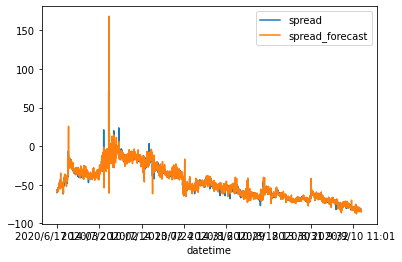

In [10]:
spread_prediction = prediction[["spread","spread_forecast"]]
spread_prediction.plot()

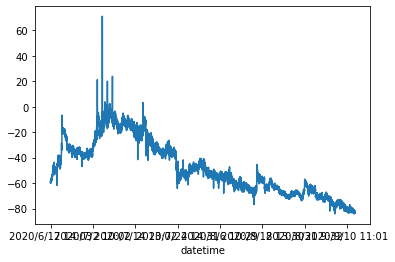

In [11]:
spread_real = prediction["spread"]
spread_real.plot()

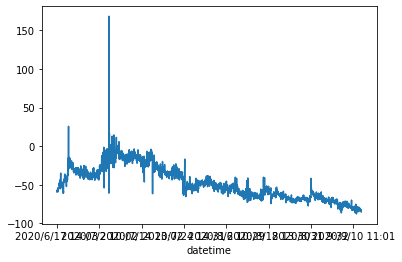

In [12]:
spread_prediction = prediction["spread_forecast"]
spread_prediction.plot()

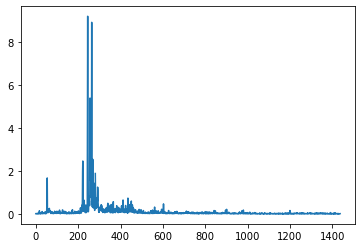

In [13]:
mape_accuracy = accuracy["mape"]
mape_accuracy.plot()